In [35]:
import numpy as np
import strax
import straxen
import pandas as pd
import nestpy   
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
import RLdeconvolution
import Selection
from datetime import datetime 
import json

In [2]:
#check straxen and wfsim version
print(straxen.__file__,'\n',wfsim.__file__)

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen/__init__.py 
 /home/changcai/.local/lib/python3.8/site-packages/wfsim/__init__.py


In [3]:
straxen.print_versions(('strax', 'straxen'))

Working on midway2-0417.rcc.local with the following versions and installation paths:
python	v3.8.11	(default, Aug  3 2021, 15:09:35) [GCC 7.5.0]
strax	v0.16.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen	v0.19.3	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen


选取数据，以run 21445为例，选取顶部事件，比较S1的顶部与底部波形差异，进行解卷积，得到光传播时间分布
=====
当然这个过程可以简化，直接对TOP和BOTTOM的data加上人为的diffusion即可

In [4]:
run_id = '021445'
st = straxen.contexts.xenonnt_online(_add_online_monitor_frontend=True)
st = straxen.contexts.xenonnt_online(output_folder='/home/changcai/scratch-midway2')
st.storage.append(strax.DataDirectory('/dali/lgrandi/xenonnt/nveto/processed/', readonly=True))

In [5]:
data = st.get_array('021445','raw_records',seconds_range=(0,1))

Loading raw_records: |          | 0.00 % [00:00<?]

In [6]:
len(data)

107690

In [7]:
# Check if the 'event-info' of this run_id is available,if not:
#st.make(run_id,'event_info')
#this may take some time

In [8]:
events_info = st.get_array(run_id,'event_info',seconds_range = (0,40))

Loading event_info: |          | 0.00 % [00:00<?]

In [10]:
#Select those events happened between z=-1 and z=0
#Be careful that not all the events are S1S2 pairs, some may even have events_info['z']>0 
selectdown = events_info['z']> -1 
selectup = events_info['z']< 0 
select = selectdown*selectup
top_events = events_info[select]

281 64


(array([ 6.,  1.,  2.,  1.,  5.,  4.,  4.,  4., 11., 26.]),
 array([-9.7799420e-01, -8.8020158e-01, -7.8240889e-01, -6.8461627e-01,
        -5.8682358e-01, -4.8903096e-01, -3.9123830e-01, -2.9344565e-01,
        -1.9565301e-01, -9.7860351e-02, -6.7699999e-05], dtype=float32),
 <BarContainer object of 10 artists>)

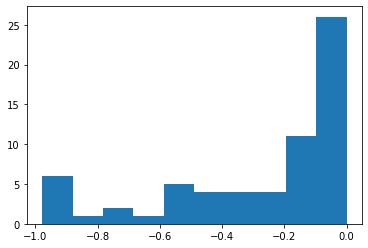

In [11]:
#If you want to check the data
print(len(events_info),len(top_events))
plt.hist(top_events['z'])

In [12]:
#Load the records of the range
records = st.get_array(run_id,'records',seconds_range=(0,40))

Loading records: |          | 0.00 % [00:00<?]

In [13]:
#Check the records data volume in mb, keep it smaller than the ram you could use
records.nbytes/1e6

835.4556

In [36]:
a=datetime.now() 
for i in range(len(top_events)):
    #get the first S1 and S2information
    S1records, [s1start,s1end], S2records ,[s2start,s2end]= Selection.event_records_selection(records,top_events[i])
b=datetime.now()

In [37]:
b-a

datetime.timedelta(seconds=26, microseconds=686347)

In [15]:
#The channels belong to the top and bottom array
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
#the adc_to_pe map
cmt=straxen.CorrectionsManagementServices()
topemap = cmt.get_pmt_gains(run_id,'to_pe_model','ONLINE') #this would give you the actual gains 

In [33]:
#get the waveform of the S1 top and bottom array 
topS1data = Selection.sumrecords(S1records,channeltop,s1start,s1end,topemap)
bottomS1data = Selection.sumrecords(S1records,channelbottom,s1start,s1end,topemap)
#get the waveform of the S1 top and bottom array 
topS2data = Selection.sumrecords(S2records,channeltop,s2start,s2end,topemap)
bottomS2data = Selection.sumrecords(S2records,channelbottom,s2start,s2end,topemap)

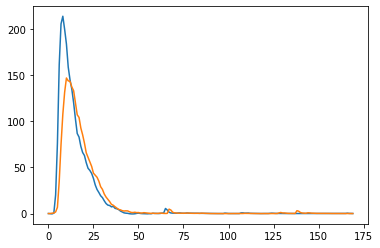

In [19]:
plt.plot(topS1data)
plt.plot(bottomS1data)

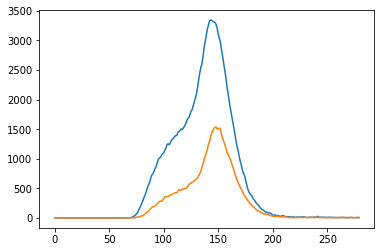

In [34]:
plt.plot(topS2data)
plt.plot(bottomS2data)

In [29]:
new_up = np.append(np.zeros(len(topS1data) - 1), topS1data)
new_up = np.roll(new_up,-10)/np.sum(new_up)
new_bottom = np.append(bottomS1data,np.zeros(len(bottomS1data) - 1))/np.sum(bottomS1data)
new_bottom = np.append(new_bottom[:50],np.zeros(len(new_bottom)-50))

<ipython-input-31-7703211d2767>:1: RuntimeWarning: invalid value encountered in true_divide
  array = new_bottom/np.convolve(new_bottom, new_up, mode='same')


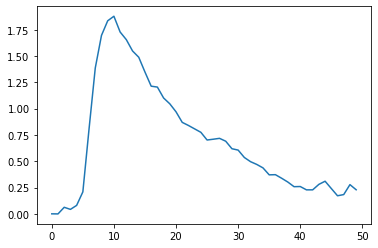

In [31]:
array = new_bottom/np.convolve(new_bottom, new_up, mode='same')
plt.plot(array[:50])

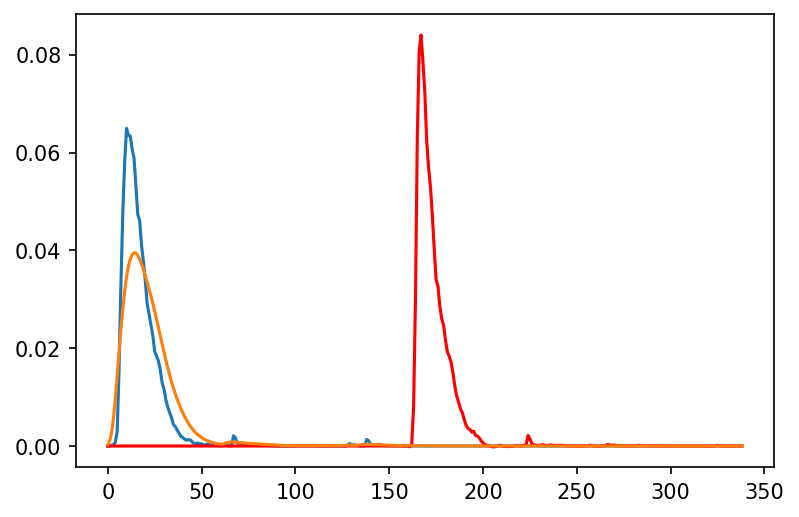

In [27]:
plt.figure(dpi = 150)
plt.plot(new_bottom)
plt.plot(new_up,color = 'red')
plt.plot(np.convolve(new_bottom, new_up, mode='same'))

In [24]:
#before the deconvolution, we need to make sure that the length of bottom*up is no longer than the length of bottom or up signal
#put the up signal into the middle
time_diffusion = RLdeconvolution.lucydconv(new_bottom, new_up,100)

/home/changcai/reconstruction/RLdeconvolution.py:34: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = lowwave / np.convolve(low_deconv, upwave, mode='same')


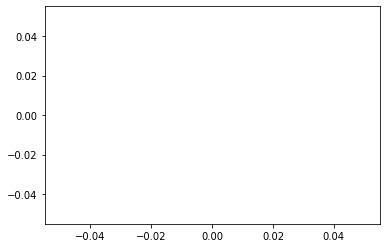

In [25]:
plt.plot(time_diffusion[1])